# Datathon Mayo 2018  **_"Haciendo el gasto fiscal visible para el público"_**
## Gasto Neto Mensualizado por año de las Instituciones Públicas

## Lectura de Datos

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
# import pandas_profiling as pd_profiling
import altair as alt

alt.data_transformers.enable('json')
# alt.data_transformers.enable('default', max_rows=10000)

DataTransformerRegistry.enable('json')

In [2]:
def read_field_type(x):
    '''
    Para facilitar la lectura de los dataframes con los tipos de columna correspondientes.
    '''
    if x in ['String']:
        return str
    elif x in ['Integer', 'Long']:
        return int
    else:
        return str

In [3]:
pub_spend_names = pd.read_csv(os.path.join('data', 
                              'dataset_1_monthly_spend_2009-2017_DICTIONARY.csv'), 
                              sep=';', 
                              encoding='utf-8')

In [4]:
pub_spend_names

,Field name,Field type,Field size,Field format,Range,Description,Example
0,Periodo,Integer,15,#,2009 to 2017,Year of the spend,2009
1,Nombre Partida,String,63,NaN,28 categories,Ministeries,Ministerio de Educación
2,Nombre Capitulo,String,78,NaN,219 categories,Public Services,Fondo Nacional de Salud
3,Nombre Programa,String,78,NaN,363 categories,Programs,Fondo Nacional de Salud
4,Nombre Subtitulo,String,37,NaN,10 categories,First level of the budget classification,TRANSFERENCIAS CORRIENTES
5,Nombre Item,String,54,NaN,43 categories,Second level of the budget classification,Al Sector Privado
6,Nombre Asignación,String,250,NaN,4372 categories,Third level of the budget classification,Subsidios Fondo Solidario de Vivienda
7,Nombre SubAsignación,String,80,NaN,1355 categories,Last level of the budget classification,Asistencia Técnica
8,Mes,String,10,NaN,12 categories,Month,enero
9,Monto,Integer,15,#,(-49702217) to 357607483,"Amount, this data was update by the inflation ...",357607483


In [5]:
pub_spend_names.iloc[9, 5]

"Amount, this data was update by the inflation factors, and it's expressed in thousands of pesos"

In [6]:
pub_spend = pd.read_csv(os.path.join('data', 
                              'dataset_1_monthly_spend_2009-2017.csv'),
                 sep=';', 
                 encoding='utf-8',
                 dtype=dict(zip(pub_spend_names['Field name'], pub_spend_names['Field type'].apply(read_field_type))))

In [7]:
pub_spend.head(5) 

,Periodo,Nombre Partida,Nombre Capitulo,Nombre Programa,Nombre Subtitulo,Nombre Item,Nombre Asignación,Nombre SubAsignación,Mes,Monto_sum
0,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Abril,0
1,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Agosto,0
2,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Diciembre,0
3,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Enero,0
4,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Febrero,0


In [8]:
pub_spend.columns = ['periodo', 'partida', 'capitulo', 'programa', 'subtitulo', 'item', 'asignacion', 'subasignacion', 'mes', 'gasto']

In [9]:
pub_spend.shape

(3110448, 10)

In [10]:
pub_spend = pub_spend[pub_spend['gasto'] != 0]

In [11]:
pub_spend.shape

(2107310, 10)

In [12]:
# pub_spend = pub_spend.sample(frac=0.2, random_state=42)
# pub_spend.shape

In [13]:
def mbSize(obj):
    return round(sys.getsizeof(obj) / 1024 / 1024.0, 2)

mbSize(pub_spend)

1425.51

# Estadística descriptiva

## Gasto anual

In [14]:
es_month_dict = {'enero': 1,
                 'febrero': 2,
                 'marzo': 3, 
                 'abril': 4,
                 'mayo': 5,
                 'junio': 6,
                 'julio': 7,
                 'agosto': 8,
                 'septiembre': 9,
                 'octubre': 10,
                 'noviembre': 11,
                 'diciembre': 12
                }

pub_spend['month'] = pub_spend['mes'].str.lower().map(es_month_dict)
pub_spend['day'] = 15
pub_spend['date'] = pd.to_datetime(pub_spend[['day', 'month', 'periodo']].rename(columns={'periodo': 'year'}))
pub_spend.drop(['periodo', 'mes', 'month', 'day'], axis=1, inplace=True)

## Agregaciones

Quitando el cuarto nivel de presupuesto (Subasignacion) se tiene que:

In [15]:
pub_spend_agg3 = pub_spend.groupby(['partida', 'capitulo', 'programa', 'subtitulo', 'item', 'asignacion', 'date'])['gasto'].sum().reset_index()

In [16]:
mbSize(pub_spend_agg3)

909.06

In [17]:
mbSize(pub_spend_agg3) / mbSize(pub_spend) * 100

62.55832197861183

Quitando el cuarto y tercer nivel de presupuesto (Subasignacion y Asignacion) se tiene que:

In [18]:
pub_spend_agg2 = pub_spend.groupby(['partida', 'capitulo', 'programa', 'subtitulo', 'item', 'date'])['gasto'].sum().reset_index()

In [19]:
mbSize(pub_spend_agg2)

261.89

In [20]:
mbSize(pub_spend_agg2) / mbSize(pub_spend) * 100

18.022351597230823

In [21]:
pub_spend_agg1 = pub_spend.groupby(['partida', 'capitulo', 'programa', 'subtitulo', 'date'])['gasto'].sum().reset_index()

In [22]:
mbSize(pub_spend_agg1)

60.78

In [23]:
mbSize(pub_spend_agg1) / mbSize(pub_spend) * 100

4.182666501507081

In [24]:
pub_spend_names

,Field name,Field type,Field size,Field format,Range,Description,Example
0,Periodo,Integer,15,#,2009 to 2017,Year of the spend,2009
1,Nombre Partida,String,63,NaN,28 categories,Ministeries,Ministerio de Educación
2,Nombre Capitulo,String,78,NaN,219 categories,Public Services,Fondo Nacional de Salud
3,Nombre Programa,String,78,NaN,363 categories,Programs,Fondo Nacional de Salud
4,Nombre Subtitulo,String,37,NaN,10 categories,First level of the budget classification,TRANSFERENCIAS CORRIENTES
5,Nombre Item,String,54,NaN,43 categories,Second level of the budget classification,Al Sector Privado
6,Nombre Asignación,String,250,NaN,4372 categories,Third level of the budget classification,Subsidios Fondo Solidario de Vivienda
7,Nombre SubAsignación,String,80,NaN,1355 categories,Last level of the budget classification,Asistencia Técnica
8,Mes,String,10,NaN,12 categories,Month,enero
9,Monto,Integer,15,#,(-49702217) to 357607483,"Amount, this data was update by the inflation ...",357607483


In [25]:
pub_spend_agg2_without_programa = pub_spend.groupby(['partida', 'capitulo', 'subtitulo', 'item', 'date'])['gasto'].sum().reset_index()

In [26]:
print(mbSize(pub_spend_agg2_without_programa))
print(mbSize(pub_spend_agg2_without_programa) / mbSize(pub_spend) * 100)

166.64
11.467580549706152


## Gasto Anual

In [27]:
pub_spend_agg2_dict = alt.to_json(pub_spend_agg2, prefix='pub_spend_agg2')

In [28]:
pub_spend_agg1_dict = alt.to_json(pub_spend_agg1, prefix='pub_spend_agg1')

In [29]:
pub_spend_base = alt.Chart().encode(
    x=alt.X('date:T', 
        timeUnit='year',
        axis=alt.Axis(title='Año'),
           ),
    y=alt.Y('sum(gasto):Q', axis=alt.Axis(format="($,.2r", title='Miles de Pesos Chilenos'))
)

In [32]:
pub_spend_chart = alt.layer(
    pub_spend_base.mark_point(),
    pub_spend_base.mark_line(),
#     pub_spend_base.mark_text(dy=-10, dx=-5).encode(text=alt.Text('sum(gasto):Q', format="$.2s")), 
    data=pub_spend_agg1_dict['url']
).properties(
    title='Gasto Anual',
    width=600, 
    height=400 
)

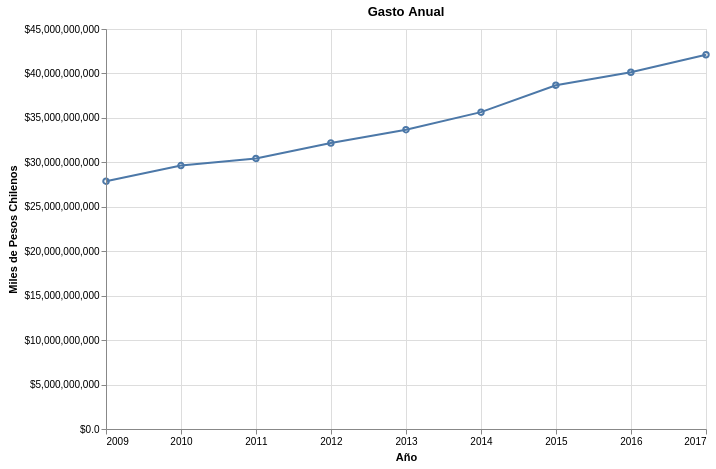

In [36]:
# pub_spend_chart.save(os.path.join('charts', 'gasto_anual.json'))
pub_spend_chart

## Gasto Año-Mes

In [34]:
monthly_year_spend_chart = alt.layer(
    pub_spend_base.mark_point().encode(
        x=alt.X('date:T', 
            timeUnit='yearmonth',
            axis=alt.Axis(title='Fecha')
            )
        ),
    pub_spend_base.mark_line().encode(
        x=alt.X('date:T', 
            timeUnit='yearmonth',
            axis=alt.Axis(title='Fecha')
            )
        ),
    data=pub_spend_agg1_dict['url']
).properties(
    title='Gasto Mensual',
    width=800, 
    height=400 
)


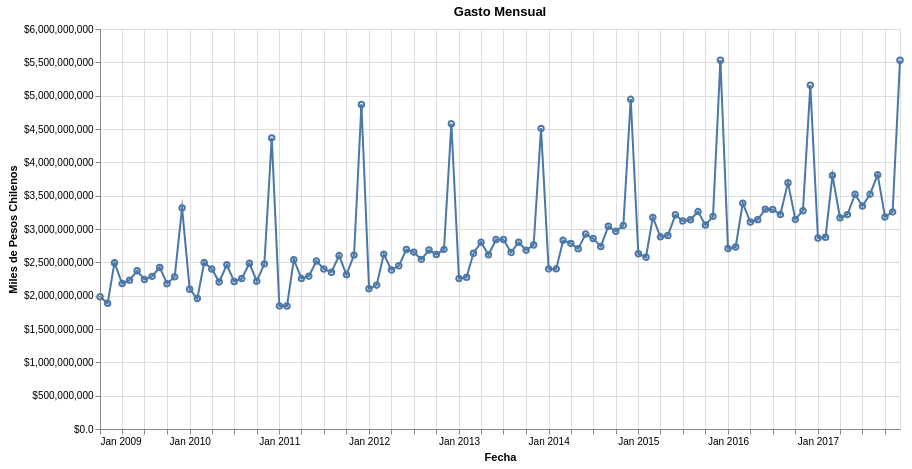

In [71]:
# monthly_year_spend_chart.save(os.path.join('charts', 'gasto_mensual_anual.json'))
monthly_year_spend_chart

## Gasto Anual por Partida

In [38]:
from altair import datum

In [59]:
gasto_promedio_anual_partida = pub_spend_agg1.groupby(['partida', pd.Grouper(key='date', freq='1Y')])['gasto'].sum().groupby(level=0).mean().sort_values(ascending=False)

In [44]:
ministry_anual_pub_spend = alt.Chart(pub_spend_agg1_dict['url']).mark_bar().encode(
    x=alt.X('sum(gasto):Q', axis=alt.Axis(format="($,.2r", title='Miles de Pesos Chilenos')),
    y=alt.Y('partida:N', axis=alt.Axis(title='Partida')),
    color=alt.Color('date:O', 
            timeUnit='year'),
    tooltip=alt.Tooltip('date:O', 
            timeUnit='year'),
).properties(
    title='Gasto Anual por Partida',
    width=700, 
    height=700 
)

In [64]:
ministry_mean_pub_spend = alt.Chart(gasto_promedio_anual_partida.reset_index()).mark_bar().encode(
    x=alt.X('sum(gasto):Q', axis=alt.Axis(format="($,.2r", title='Miles de Pesos Chilenos')),
    y=alt.Y('partida:N', axis=alt.Axis(title='Partida')),
    tooltip=alt.Tooltip('sum(gasto):Q', format="($,.2r")
).properties(
    title='Gasto Promedio Anual por Partida',
    width=700, 
    height=700 
)

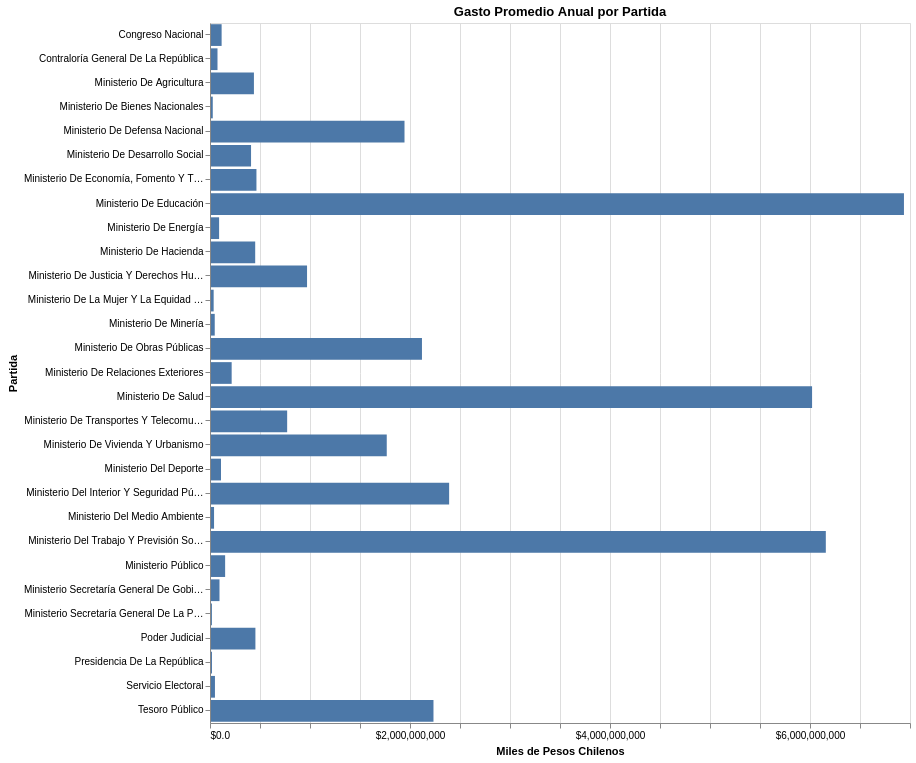

In [65]:
# ministry_mean_pub_spend.save(os.path.join('charts', 'gasto_promedio_anual_por_partida.json'))
ministry_mean_pub_spend

In [66]:
ministry_anual_pub_spend_base = alt.Chart(pub_spend_agg1_dict['url']).mark_line(strokeWidth=2.5).encode(
    x=alt.X('date:T', 
        timeUnit='year',
        axis=alt.Axis(title='Año')
           ),
    y=alt.Y('sum(gasto):Q', 
            axis=alt.Axis(format="($,.2r", title='Miles de Pesos Chilenos')),
).properties(
    title='Gasto Anual por Partida',
    width=600, 
    height=400 
)

In [67]:
ministry_anual_pub_spend_highlight = ministry_anual_pub_spend_base.encode(color=alt.Color('partida:N', scale=None, title=None)) + ministry_anual_pub_spend_base.encode(color=alt.Color('partida:N', title='Partida')).transform_filter(
    (datum.partida == gasto_promedio_anual_partida.index[0]) | (datum.partida == gasto_promedio_anual_partida.index[1]) | (datum.partida == gasto_promedio_anual_partida.index[2]))

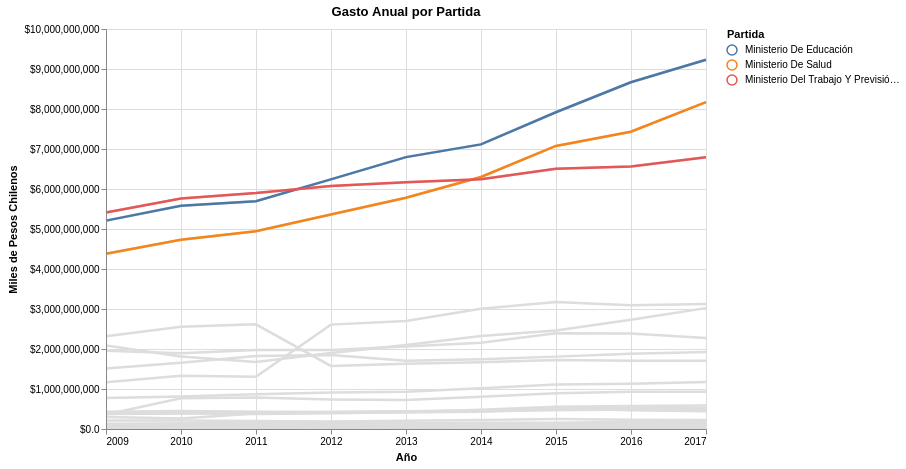

In [69]:
ministry_anual_pub_spend_highlight.save(os.path.join('charts', 'gastoAnualPorPartidaMayores.json'))
ministry_anual_pub_spend_highlight

In [ ]:
# alt.Chart(pub_spend_agg1_dict['url']).mark_line(strokeWidth=3).encode(
#     x=alt.X('date:T', 
#         timeUnit='year',
#         axis=alt.Axis(title='Año')
#            ),
#     y=alt.Y('sum(gasto):Q', 
#             axis=alt.Axis(format="($,.2r", title='Miles de Pesos Chilenos')),
#     color='partida:N',
#     tooltip='partida:N',
# ).properties(
#     title='Gasto Anual por Partida',
#     width=600, 
#     height=400 
# )

## Gasto Mensual por Partida en cada Año

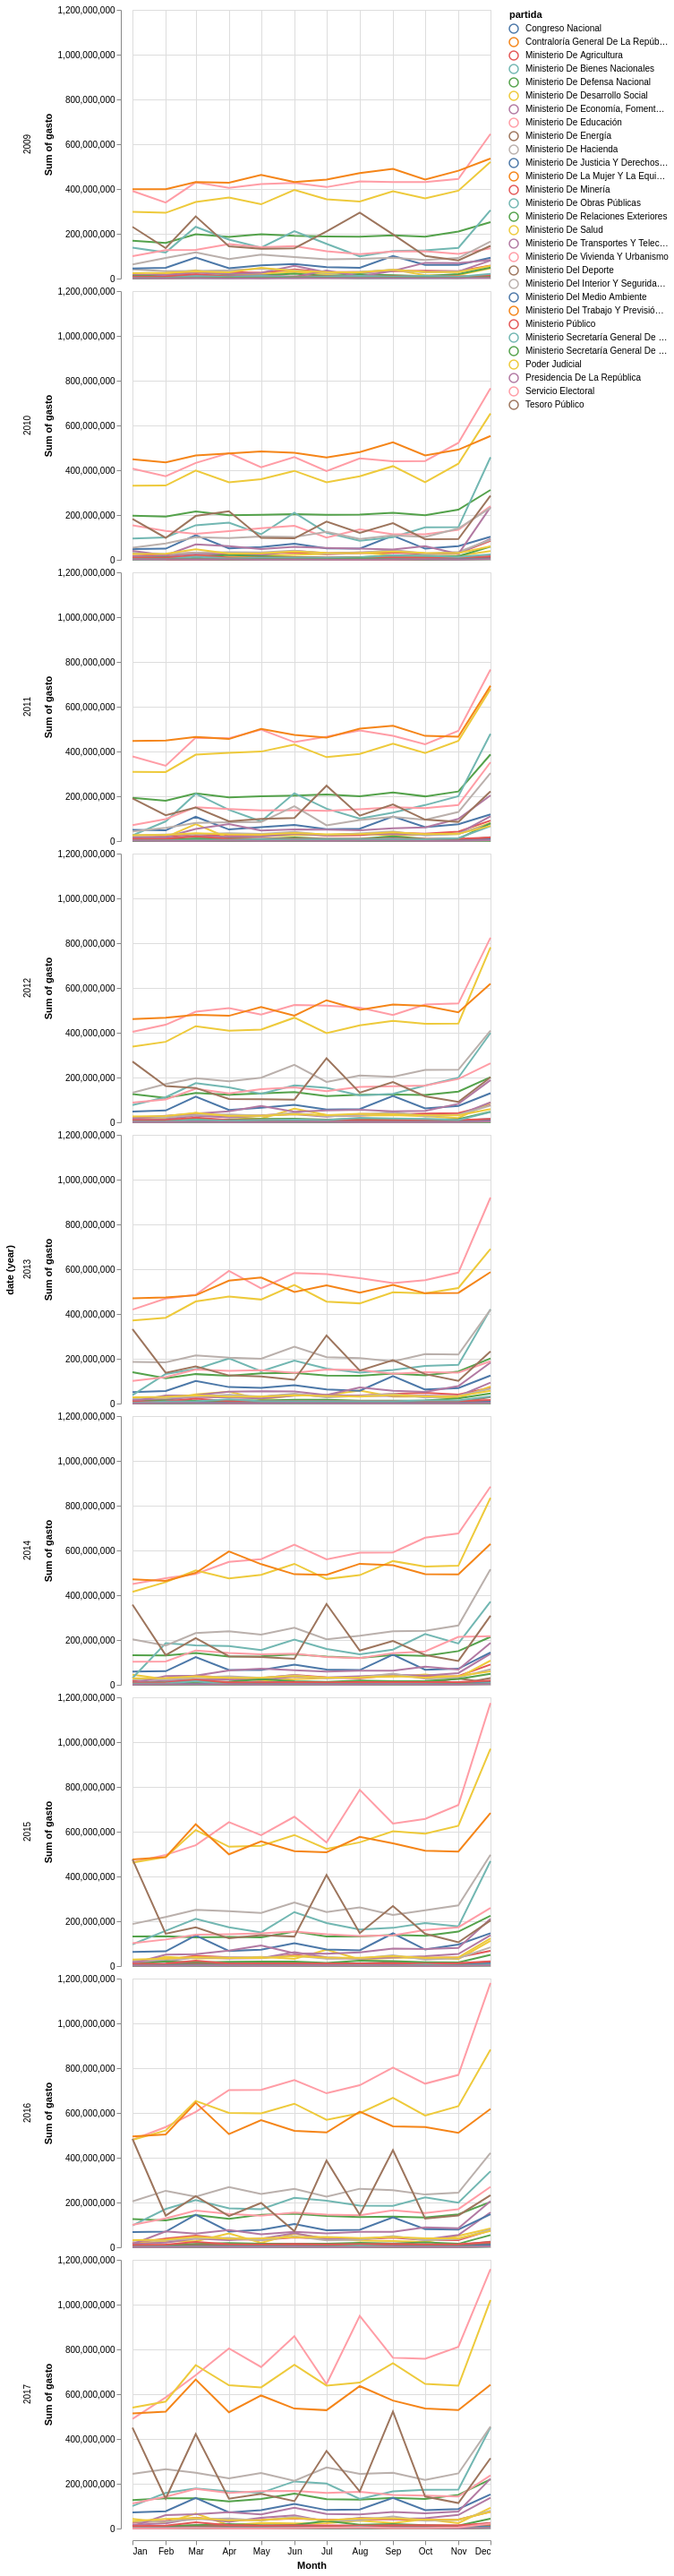

In [70]:
alt.Chart(pub_spend_agg1_dict['url']).mark_line().encode(
    x=alt.X('date:T', 
            timeUnit='month',
            axis=alt.Axis( title='Month')
           ),
    y='sum(gasto):Q',
    color='partida:N',
    row=alt.Row('date:T', 
            timeUnit='year'
           ),
)

## Conteo de registros vs Gasto

### Por Partida

In [ ]:
alt.Chart(pub_spend_agg1_dict['url']).mark_line().encode(
    x=alt.X('date:T', 
            timeUnit='year',
            axis=alt.Axis( title='Month')
           ),
    y='count()',
    color='partida:N',
    tooltip='partida:N',
).properties(
    title='Conteo Anual de Registros por Partida',
    width=600, 
    height=400 
)

In [ ]:
aux_line + aux_line.mark_point() | aux_line.encode(y='sum(gasto):Q') + aux_line.mark_point().encode(y='sum(gasto):Q')

### Por capítulo

In [ ]:
# aux_line.encode(color='capitulo') + aux_line.mark_point().encode(color='capitulo')

### Por Subtítulo

In [ ]:
aux_line.encode(color='subtitulo') + aux_line.mark_point().encode(color='subtitulo') | aux_line.encode(y='sum(gasto):Q', color='subtitulo') + aux_line.mark_point().encode(y='sum(gasto):Q', color='subtitulo')

### Por Item

In [ ]:
aux_line.encode(color='item') + aux_line.mark_point().encode(color='item') | aux_line.encode(y='sum(gasto):Q', color='item') + aux_line.mark_point().encode(y='sum(gasto):Q', color='item')

## Quién gasta

In [ ]:
pub_spend_agg2_without_programa_dict =  alt.to_json(pub_spend_agg2_without_programa, prefix='pub_spend_agg2_whitout_programa')

In [ ]:
alt.Chart(pub_spend_agg1_dict['url']).mark_line().encode(
    x=alt.X('date:T', 
            timeUnit='year',
            axis=alt.Axis( title='Año')
           ),
    y='sum(gasto):Q',
    color=alt.Color('capitulo:N', legend=None),
    tooltip='capitulo:N',
).properties(
    title='Gasto Anual por Capitulo',
    width=600,
    height=400,
)

In [ ]:
data = pd.DataFrame({"Day": range(1, 16),
                     "Value": [54.8, 112.1, 63.6, 37.6, 79.7, 137.9, 120.1, 103.3,
                               394.8, 199.5, 72.3, 51.1, 112.0, 174.5, 130.5]})

data2 = pd.DataFrame([{"ThresholdValue": 300, "Threshold": "hazardous"}])

bar1 = alt.Chart(data).mark_bar().encode(
    x='Day:O',
    y='Value:Q'
)

bar2 = alt.Chart(data).mark_bar(color="#e45755").encode(
    x='Day:O',
    y='baseline:Q',
    y2='Value:Q'
).transform_filter(
    "datum.Value >= 300"
).transform_calculate(
    "baseline", "300"
)

rule = alt.Chart(data2).mark_rule().encode(
    y='ThresholdValue:Q'
)

text = alt.Chart(data2).mark_text(
    align='left', dx=215, dy=-5
).encode(
    alt.Y('ThresholdValue:Q', axis=alt.Axis(title='PM2.5 Value')),
    text=alt.value('hazardous')
)

bar1 + text + bar2 + rule

## ¿Cómo gastan?

# Perfil por Partida

In [ ]:
pub_spend_agg2_without_programa.columns

In [ ]:
partida_name = 'Ministerio De Educación'

In [ ]:
partida = pub_spend[pub_spend['partida'] == partida_name]

In [ ]:
partida_chart = alt.Chart(partida).mark_line().encode(
    x=alt.X('date:T', 
            timeUnit='year',
            axis=alt.Axis( title='Year')
           ),
    y='sum(gasto):Q',
).properties(
    width=600,
    height=400,
)

## Quién gasta

In [ ]:
partida_chart.encode(color='capitulo:N') + partida_chart.mark_point().encode(color='capitulo:N') 

In [ ]:
partida_chart.encode(color='programa:N') + partida_chart.mark_point().encode(color='programa:N') 

## Cómo se gasta

In [ ]:
partida_chart.encode(color='subtitulo:N') + partida_chart.mark_point().encode(color='subtitulo:N')

In [ ]:
partida_chart.encode(color='item:N') + partida_chart.mark_point().encode(color='item:N')